In [1]:
import scipy.io as sio
import numpy as np
import os
import pandas as pd

import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import gudhi

## Source Data

Paper [link](https://www.nature.com/articles/s41467-021-24336-w)

Github repo [link](https://github.com/alxdroR/SRNatComm21)


Lab Current Code : https://github.com/alxdroR/zfOcMotor/tree/greg

In [2]:
from Trajectory import zfSessionData

## Loading main data

In [2]:
base_dir = "/Users/samart/Documents/Geometric DA/Final Project/RamirezPaperData/analyzedBehaviorAndImaging"
traces = os.path.join(base_dir, "CaTracesAndFootprints/")
behavior = os.path.join(base_dir, "behavior10to20Hz/")


In [29]:
muf = sio.loadmat(traces + "f1_traces_EPSelect.mat")
muf.keys()

dict_keys(['__header__', '__version__', '__globals__', 'expMetaData', 'filenames', 'fluorescence', 'filtFl', 'frate', 'Por', 'b2', 'f2', 'localCoordinates', 'A', 'twitchFrames', 'twitchTimes', 'MCerror', 'syncOffset', 'cellSelectParam'])

In [30]:
class zfSessionData:
    def __init__(self, fish=[], method='ep'):
        self.base_dir = "/Users/samart/Documents/Geometric DA/Final Project/RamirezPaperData/analyzedBehaviorAndImaging"        
        self.traces = os.path.join(self.base_dir, "CaTracesAndFootprints/")
        self.behavior = os.path.join(self.base_dir, "behavior10to20Hz/")
        # A is output of CaImAn, Gaussian Centered around cell locations
        # A binary is a binary mask that tells where cells are; A itself pretty much useless

        EP = [s for s in os.listdir(self.traces) if "traces_EPSelect" in s] # CaImAN
        IM = [s for s in os.listdir(self.traces) if "traces_IMOpenSelect" in s] # avg intensity
        self.files = EP if method == 'ep' else IM
        self.method = method.lower()
        self.fish_names = [s.split('_')[0] for s in self.files]
        self.fish_names.sort()
        
        self.data = {}     
        for f in fish:
            print(f"Parsing {f} data")
            self.parse_trace(f)

    def get_filename(self, fish):
        if(self.method == 'ep'):
            return(f"{fish}_traces_EPSelect.mat")
        elif(self.method == 'im'):
            return(f"{fish}_traces_IMOpenSelect.mat")
        
    def parse_trace(self, fish):
        filename = self.get_filename(fish)
        data = sio.loadmat(os.path.join(self.traces, filename))
        cellLocs = [file[0] for file in data['localCoordinates']]
        fluor = [file[0] for file in data['fluorescence']]
        num_samples = fluor[0].shape[1] # num_cells x num_samples
        file_data = {
            'fluor' : fluor,
            'cellLocations' : cellLocs,
            'num_samples' : num_samples,
        }
        self.data[fish] = file_data
        return(data)

    def load_behavior(self, fish, idx):
        fname = os.path.join(self.behavior, f"{fish}_{idx}.mat")
        data = sio.loadmat(fname)
        return(data)

    def load_motor_trajectory(self, norm=False):
        df = pd.read_csv("motor_data.csv").drop(['Unnamed: 0'], axis=1)
        t, N = df.values.shape # num_samples x num_cells
        da = xr.DataArray(df.values.T, dims=('N', 'T'), coords={'N' : np.arange(1, N+1), 'T' : np.arange(0, t)})
        if(norm):
            da = (da - da.mean(dim='T')) / da.mean(dim='T')
        return(da)
    
    def load_fish_trajectory(self, fish, idx):
        # idx belongs to different OG tiff files (RHB vs non RHB?), likely z planes
        fluor = self.data[fish]['fluor'][idx]
        loc = self.data[fish]['cellLocations'][idx]
        # dF/F
        temporal_mean = np.mean(fluor, axis=1).reshape(-1, 1)
        dFF = (fluor - temporal_mean) / temporal_mean

        N, t = dFF.shape
        da = xr.DataArray(dFF, dims=('N', 'T'), coords={'N' : np.arange(1, N+1), 'T' : np.arange(0, t), 
                                                        'X' : (('N',), loc[:,0]), 'Y' : (('N',), loc[:,1])})
        
        return(da)

In [31]:
zf = zfSessionData(['f1'])

Parsing f1 data


In [20]:
da = zf.load_motor_trajectory(True)

In [21]:
zf.data['f1']['cellLocations'][2]

array([[107.97604999, 364.92869762],
       [138.32277128, 502.39136487],
       [136.56898413, 474.74172388],
       [ 88.54069708, 361.15932442],
       [ 87.25638037,  57.33936519],
       [  5.45634071, 133.79771293],
       [ 53.15621192,  47.39353067],
       [395.62413975, 222.82432957],
       [ 80.22708233, 144.62048729],
       [163.92881355, 503.4435264 ],
       [ 72.92984497, 375.61033943],
       [180.58536061, 116.87960927],
       [ 21.68323116, 200.54244648],
       [ 28.9400884 , 283.05210672],
       [152.40205032, 241.95009976],
       [370.92001341, 211.59557526],
       [ 73.62499306, 300.0179954 ],
       [128.4813555 , 228.20469686],
       [105.39954884, 375.51948791],
       [126.09924068, 503.2584571 ],
       [ 48.25119603, 249.51351441],
       [ 75.69647059, 365.64569234],
       [443.29316467, 503.98191224],
       [ 89.11786736, 373.13185466],
       [  7.70346049, 150.70917825],
       [ 12.51850616, 272.2477415 ],
       [140.88535712, 223.683953  ],
 

In [22]:
trajectory = zf.load_fish_trajectory('f1', 5)
trajectory

<xarray.DataArray (N: 217, T: 234)>
array([[ 1.34475294e+00,  1.63932110e+00,  2.41911423e-02, ...,
        -8.12626855e-02, -5.89699090e-02,  5.04013742e-03],
       [ 7.91648975e-01,  9.71706554e-01,  5.50518296e-01, ...,
        -9.57790304e-02, -4.79528545e-02, -2.77173271e-02],
       [ 1.92209472e+00,  1.71500996e+00,  7.64923639e-02, ...,
        -2.59560942e-02, -3.19786792e-02,  4.16475605e-02],
       ...,
       [ 1.90971591e+00,  2.35363957e+00,  2.18652081e-01, ...,
        -7.82914683e-02,  5.67942502e-02, -8.85319473e-04],
       [ 2.41204772e+00,  2.33918624e+00,  1.08946152e-01, ...,
         9.10983513e-03,  8.98055545e-02,  1.49998135e-01],
       [ 2.25467161e+00,  2.14468769e+00,  7.16177997e-01, ...,
        -1.20528876e-01, -7.73655966e-02, -4.11052082e-02]])
Coordinates:
  * N        (N) int64 1 2 3 4 5 6 7 8 9 ... 209 210 211 212 213 214 215 216 217
  * T        (T) int64 0 1 2 3 4 5 6 7 8 ... 225 226 227 228 229 230 231 232 233
    X        (N) float64 38.95 152.7 342.8 161.8 ... 125.4 97.22 423.7 420.8
    Y        (N) float64 288.8 158.3 449.5 482.6 ... 486.3 469.5 394.8 449.4

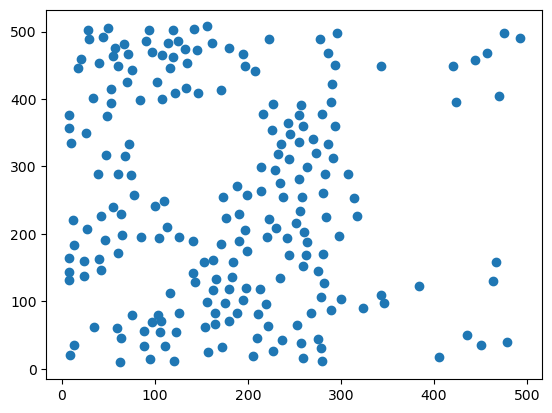

In [23]:
plt.scatter(trajectory.X, trajectory.Y)

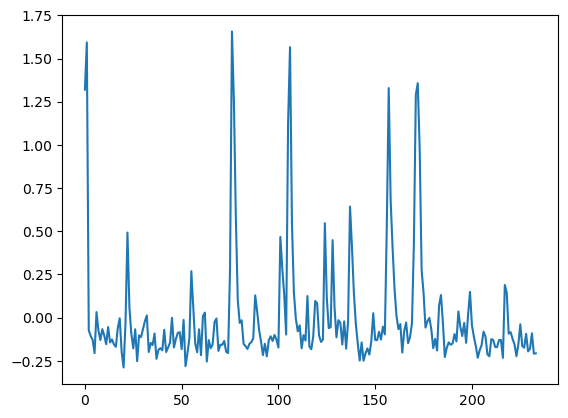

In [24]:
plt.plot(trajectory.sel(N=18))

## Segmenting by Behavior

In [12]:
behavior_files = os.listdir(zf.behavior)
behavior_files.sort()
behavior_files

['f11_1.mat',
 'f11_10.mat',
 'f11_11.mat',
 'f11_2.mat',
 'f11_3.mat',
 'f11_4.mat',
 'f11_5.mat',
 'f11_6.mat',
 'f11_7.mat',
 'f11_8.mat',
 'f11_9.mat',
 'f12_1.mat',
 'f12_10.mat',
 'f12_11.mat',
 'f12_2.mat',
 'f12_3.mat',
 'f12_4.mat',
 'f12_5.mat',
 'f12_6.mat',
 'f12_7.mat',
 'f12_8.mat',
 'f12_9.mat',
 'f13_1.mat',
 'f13_10.mat',
 'f13_11.mat',
 'f13_12.mat',
 'f13_13.mat',
 'f13_14.mat',
 'f13_15.mat',
 'f13_16.mat',
 'f13_17.mat',
 'f13_18.mat',
 'f13_19.mat',
 'f13_2.mat',
 'f13_20.mat',
 'f13_21.mat',
 'f13_22.mat',
 'f13_23.mat',
 'f13_24.mat',
 'f13_3.mat',
 'f13_4.mat',
 'f13_5.mat',
 'f13_6.mat',
 'f13_7.mat',
 'f13_8.mat',
 'f13_9.mat',
 'f14_1.mat',
 'f14_10.mat',
 'f14_11.mat',
 'f14_12.mat',
 'f14_13.mat',
 'f14_14.mat',
 'f14_15.mat',
 'f14_16.mat',
 'f14_17.mat',
 'f14_18.mat',
 'f14_19.mat',
 'f14_2.mat',
 'f14_20.mat',
 'f14_21.mat',
 'f14_22.mat',
 'f14_23.mat',
 'f14_24.mat',
 'f14_25.mat',
 'f14_26.mat',
 'f14_27.mat',
 'f14_28.mat',
 'f14_29.mat',
 'f14_3.m

In [17]:
def load_behavior(self, fish, idx):
    fname = os.path.join(self.behavior, f"{fish}_{idx}.mat")
    data = sio.loadmat(fname)
    return(data)

In [ ]:
def load_stimulus(

In [13]:
B = zf.load_behavior('f1', 5)


In [23]:
B.keys()

dict_keys(['__header__', '__version__', '__globals__', 'leye_position', 'reye_position', 'eye_prop', 'bodyCentroid'])

In [14]:
B['eye_prop'].shape
B['eye_prop'][0]

array([array([[(array([[162.02041858, 199.40451993]]), array([[-135.61016914]]), array([[235.71649778]]), array([[161.19959408]])),
               (array([[393.64340036, 336.17090468]]), array([[-109.08530396]]), array([[243.41814676]]), array([[165.16358682]]))]],
             dtype=[('Centroid', 'O'), ('Orientation', 'O'), ('MajorAxisLength', 'O'), ('MinorAxisLength', 'O')])                    ,
       array([[(array([[162.03615188, 199.24071745]]), array([[-135.34934946]]), array([[236.17541539]]), array([[160.68221268]])),
               (array([[393.76149547, 336.18613499]]), array([[-108.6526435]]), array([[244.16368254]]), array([[164.80649698]]))]],
             dtype=[('Centroid', 'O'), ('Orientation', 'O'), ('MajorAxisLength', 'O'), ('MinorAxisLength', 'O')])                   ,
       array([[(array([[161.9837167 , 199.02136892]]), array([[-135.55798251]]), array([[235.39496082]]), array([[161.11431259]])),
               (array([[393.69662868, 336.28317167]]), array([[-108.

In [15]:
B['leye_position'].shape

(2, 3622)

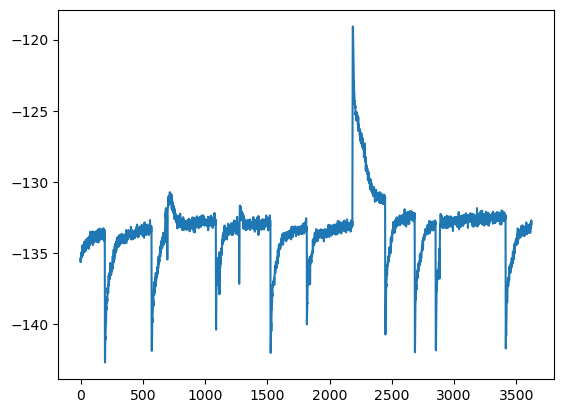

In [22]:
plt.plot(B['leye_position'][1])

In [23]:
B.keys()

dict_keys(['__header__', '__version__', '__globals__', 'leye_position', 'reye_position', 'eye_prop', 'bodyCentroid'])

In [25]:
zf.fish_names[:10]

['f1', 'f11', 'f12', 'f13', 'f14', 'f16', 'f3', 'f4', 'f6', 'f7']

# Compute Simplicial Complex

In [3]:
import gudhi
import networkx as nx
from sklearn.cluster import SpectralClustering

### Zebrafish Trajectories

In [14]:
T1 = zf.load_trajectory('f1', 2)
T1 = T1.sel(N=slice(0, 20), T=slice(10, 30))
n, t = T1.shape
n, t

In [8]:
T2 = T1 + np.random.randn(n, t) / 2
(T1 - T2).max()

<xarray.DataArray ()>
array(1.60950546)

In [83]:
X = SimplicialComplex([T1, T2])
len(X.vertices), len(X.edges)

(42, 40)

In [84]:
X.construct_simplex(1.5)

In [85]:
X.simplices

{20: [[15, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19, 20, 14]],
 3: [[15, 17, 16]]}

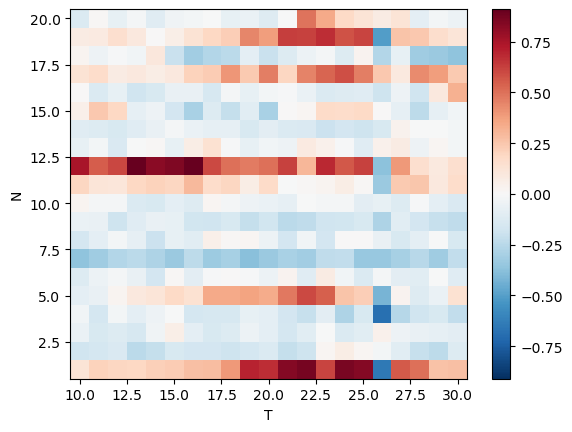

In [96]:
T1.plot()

In [93]:
times = T1['T']
dists = []
for i in range(len(times)-1):
    v, v_next = T1.isel(T=i), T1.isel(T=i+1)
    dists.append(np.linalg.norm(v-v_next))

dists

[0.41963661568218125,
 0.3077655522178241,
 0.5037436802270706,
 0.3080106153132589,
 0.4565586999092291,
 0.41284653017386885,
 0.5116032421692294,
 0.3363982474622971,
 0.5126639230871983,
 0.3816920582227738,
 0.6246321118494091,
 0.7117861668024615,
 0.6391958322559724,
 0.5543324982490815,
 0.34139073472596376,
 2.3586401962574652,
 1.8843730886832006,
 0.6414854350570189,
 0.49457922937285215,
 0.436327576991057]

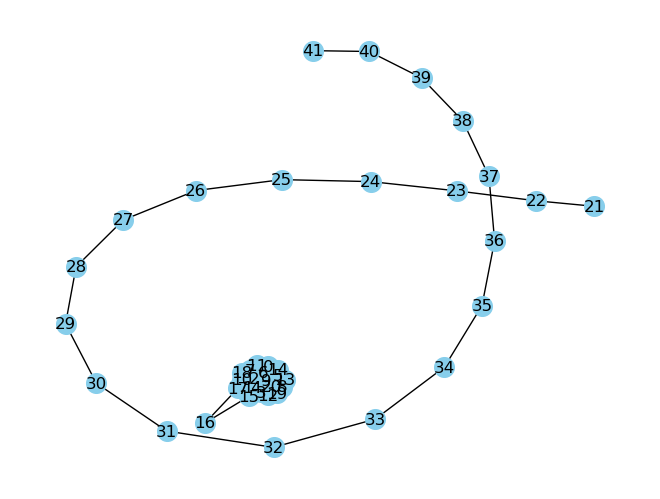

In [86]:
X.draw()

### Graph Building

In [21]:
import networkx as nx

In [18]:
X.connect_edges(1.5)
vertices = X.vertices
edges = X.edges

In [20]:
len(vertices), len(edges)

(42, 402)

In [22]:
graph = nx.Graph()
graph

In [29]:
graph.nodes[10]['vector'].shape

(20,)

In [62]:
cliques = nx.find_cliques(graph)

In [64]:
extract_simplices

{20: [[15, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19, 20, 14]],
 3: [[15, 17, 16]],
 2: [[21, 22],
  [22, 23],
  [23, 24],
  [24, 25],
  [25, 26],
  [26, 27],
  [27, 28],
  [28, 29],
  [29, 30],
  [30, 31],
  [31, 32],
  [32, 33],
  [33, 34],
  [34, 35],
  [35, 36],
  [36, 37],
  [37, 38],
  [38, 39],
  [39, 40],
  [40, 41]]}

## Motor Cells

In [5]:
zf = zfSessionData()

In [6]:
traj = zf.load_motor_trajectory(norm=True)

In [7]:
traj_sampled = traj.isel(T=slice(None, None, 10))

In [8]:
traj = zf.load_motor_trajectory(norm=True)
traj_sampled = traj.isel(T=slice(None, None, 10))
X = SimplicialComplex([traj_sampled])

NameError: name 'SimplicialComplex' is not defined

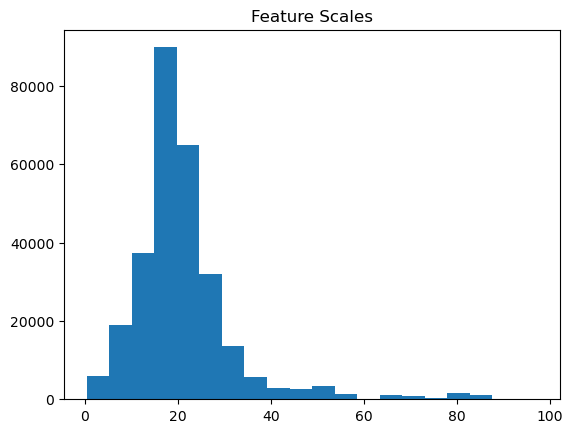

In [203]:
dists = X.pairwise_distances.flatten()
dists = dists[dists > 0]
counts, bins, bar = plt.hist(dists, density=False, bins=20)
plt.title("Feature Scales")
plt.show()

In [270]:
graph = X.form_graph(eps=5)
X.graphs

Eps not found, connecting edges
Forming graph with 533 vertices and 2711 edges


{5: <networkx.classes.graph.Graph at 0x15946a8b0>}

In [263]:
edges = X.edges['trajectory'].union(X.edges[5])
set(graph.edges) == edges

True

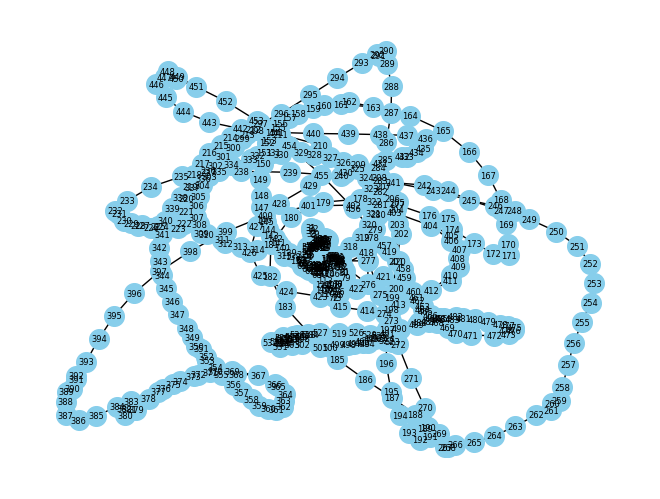

In [235]:
nx.draw(graph, with_labels=True, node_color='skyblue', node_size=200, font_size=6)
plt.show()

In [272]:
simplices = X.form_k_simplices(epsilon=5, kmax=5)

In [278]:
X.simplices[5][3]

[[147, 149, 148],
 [148, 150, 149],
 [149, 151, 150],
 [157, 159, 158],
 [158, 160, 159],
 [159, 160, 161],
 [160, 161, 162],
 [161, 163, 162],
 [174, 176, 175],
 [188, 189, 190],
 [189, 191, 190],
 [197, 198, 199],
 [198, 200, 199],
 [199, 200, 201],
 [201, 202, 203],
 [202, 204, 203],
 [206, 208, 207],
 [207, 209, 208],
 [211, 212, 213],
 [212, 214, 213],
 [213, 215, 214],
 [214, 216, 215],
 [215, 216, 217],
 [216, 217, 218],
 [217, 219, 218],
 [218, 220, 219],
 [219, 221, 220],
 [220, 222, 221],
 [221, 308, 307],
 [221, 308, 222],
 [221, 223, 222],
 [229, 231, 230],
 [230, 232, 231],
 [231, 232, 233],
 [235, 236, 237],
 [236, 238, 237],
 [241, 242, 243],
 [242, 244, 243],
 [243, 245, 244],
 [245, 246, 247],
 [246, 248, 247],
 [247, 248, 249],
 [258, 259, 260],
 [259, 261, 260],
 [260, 262, 261],
 [272, 273, 274],
 [273, 275, 274],
 [274, 276, 275],
 [275, 277, 276],
 [276, 277, 317],
 [277, 317, 318],
 [277, 278, 318],
 [277, 278, 279],
 [281, 283, 282],
 [282, 323, 322],
 [282, 323

In [34]:
"""
Class for Creating and Evaluating Feautures of Simplicial Complex
"""
import numpy as np 
import networkx as nx
import xarray as xr
import gudhi
import matplotlib.pyplot as plt
from collections import defaultdict

class SimplicialComplex:
    def __init__(self, trajectories):
        """
        Input: 
            trajectories is a list of neural time series of N dimensional vectors (Nxti) matrix). Each time series is xarray data array
            Time Series assumed to lie on k<N dimensional manifold
            Time series length does not have to be the same, N has to be same for trajectories to exist in same space
            I matrices of size N by Ti 
        """
        self.N = trajectories[0].shape[0]
        self.trajectories = trajectories
        self.vertices = []
        self.base_edges = set()
        self.homology = defaultdict(dict)
        for t in trajectories:
            self.add_trajectory(t)

        self.compute_pairwise_distances()

    def compute_pairwise_distances(self):
        vertices = np.array(self.vertices)
        V, D = vertices.shape
        pairwise_diff = vertices[:, np.newaxis, :] - vertices[np.newaxis, :, :]
        pairwise_distances = np.linalg.norm(pairwise_diff, axis=2)
        self.pairwise_distances = pairwise_distances

    def add_trajectory(self, trajectory, connect_frames=True, recompute_dists=True):
        N, T = trajectory.shape
        assert N == self.N, "trajectory dimensionality does not match" 
        for i in range(T):
            v = trajectory.isel(T=i).data
            v_index = len(self.vertices)
            self.vertices.append(v)
            if(i > 0 and connect_frames): # connect to previous state vector in trajectory
                self.base_edges.add((v_index-1, v_index))
        if(recompute_dists):
            self.compute_pairwise_distances()
        
    def connect_edges(self, epsilon):
        new_edges = []
        dists = np.triu(self.pairwise_distances, k=0) # ignore lower half
        row_indices, col_indices = np.where(np.logical_and(dists<epsilon, dists>0))
        for i, j in zip(row_indices, col_indices):
            if(i!=j):
                new_edges.append((i,j))
        self.homology[epsilon]['edges'] = set(new_edges)
        return(new_edges)

    def all_edges(self, epsilon):
        if('edges' not in self.homology[epsilon]):
            print("Eps not found, connecting edges")
            self.connect_edges(epsilon)
        edges = self.homology[epsilon]['edges']
        edges = edges.union(self.base_edges)
        return(edges)

    def form_graph(self, eps):
        graph = nx.Graph()
        for i,v in enumerate(self.vertices):
            graph.add_node(i, vector=v)
        edges = self.all_edges(eps)
        print(f"Forming graph with {len(self.vertices)} vertices and {len(edges)} edges")
        graph.add_edges_from(edges)
        self.homology[eps]['graph'] = graph
        return(graph)
        
    def form_simplices(self, epsilon, kmax):
        if('graph' in self.homology[epsilon]):
            graph = self.homology[epsilon]['graph']
        else:
            graph = self.form_graph(epsilon)
            
        cliques = nx.find_cliques(graph)
        extract_simplices = {}
        tree = gudhi.SimplexTree()
        for k in range(2, kmax+1):
            extract_simplices[k] = []
        for c in cliques:
            c.sort()
            k = len(c) - 1 # k simplex has k+1 simplices
            if(k>1 and k<=kmax):
                tree.insert(c, filtration=epsilon)
                extract_simplices[k].append(c)
        self.homology[epsilon]['simplex_sets'] = extract_simplices
        self.homology[epsilon]['tree'] = tree
        return(tree)

    def draw_graph(self, graph):
        nx.draw(graph, with_labels=True, node_color='skyblue', node_size=200, font_size=12)
        plt.show()

    def contains(self, p, st : gudhi.SimplexTree, st_type : str):
        assert st_type == 'complex' or st_type == 'precomputed', "Invalid SimplexTree type"
        """

        p is contained in a given simplex if the vector from one vertex to it is a linear combination of 
            geometrically independent basis vectors form by the sides of the face such that all coefficients are in the interval [0, 1]

        """
        simplices = st.get_simplices()
            # returns generator with tuples(simplex, filtration)
        for s, f in simplices:
            if len(s) > 1:
                M = []
                p_0 = p - s[0]
                for i in range(1, len(s)):
                    M.append(self.trajectories(s[i]) - self.trajectories(s[0]))
                M = np.array(M).T
                coeffs, res = np.linalg.lstsq(M, p_0, rcond=None) # using least-squares regression to see if it fits
                if np.max(res) < f/2 and np.min(res) > -1*f/2 and np.max(coeffs) <= 1 and np.min(coeffs) >= 0:
                    return True
        return False

    def simplex_from_distances(self, kmax):
        rc = gudhi.RipsComplex(distance_matrix = self.pairwise_distances)
        st = rc.create_simplex_tree(max_dimension=kmax)   
        return(st)

    def plot_persistence(self, simplex_tree, plot=True):
        diagram = simplex_tree.persistence()
        if(plot):
            gudhi.plot_persistence_barcode(diagram)
            plt.title("Persistence Barcode")
            plt.show()
            gudhi.plot_persistence_diagram(diagram)
            plt.title("Persistence Diagram")
            plt.show()
        return(diagram)
    
    def persist_complex(self, plot = True):
        st = gudhi.SimplexTree()
        max_val = np.max(self.pairwise_distances)
        E = np.arange(start = 0, stop = max_val + 1, step = max_val/20)

        for e in E:
            graph, s = self.construct_simplex(epsilon = e, store = False)
            filtration_val = np.ones((len(s), ))*e 
            st.insert_batch(s, filtration_val)

        diagram = st.persistence()
        if plot:
            gudhi.plot_persistence_barcode(diagram)
            plt.title("Persistence Barcode")
            plt.show()
            gudhi.plot_persistence_diagram(diagram)
            plt.title("Persistence Diagram")
            plt.show()
        return diagram, st
            
    def boundary_matrix(self):
        pass


## Representational Structures

In [35]:
import time
from Trajectory import zfSessionData
#from SimplicialComplex import SimplicialComplex
from itertools import chain, combinations

In [36]:
zf = zfSessionData()
traj = zf.load_motor_trajectory(norm=True)
traj_sampled = traj.isel(T=slice(None, None, 10))

In [37]:
X = SimplicialComplex([traj_sampled])

In [40]:
tree = X.form_simplices(5, kmax=6) # returns gudhi st object
X.homology[5].keys() # edges, graph, simplex_sets, tree

Eps not found, connecting edges
Forming graph with 533 vertices and 2711 edges


dict_keys(['edges', 'graph', 'simplex_sets', 'tree'])

In [48]:
L = 5
for simplex, filt in tree.get_filtration():
    if(len(simplex) == L):
        print("(%s, %.2f)" % tuple(simplex_with_filtration))

([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531, 532], 5.00)
([512, 513, 514, 530, 531

/Users/samart/mambaforge/envs/geometric/lib/python3.9/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


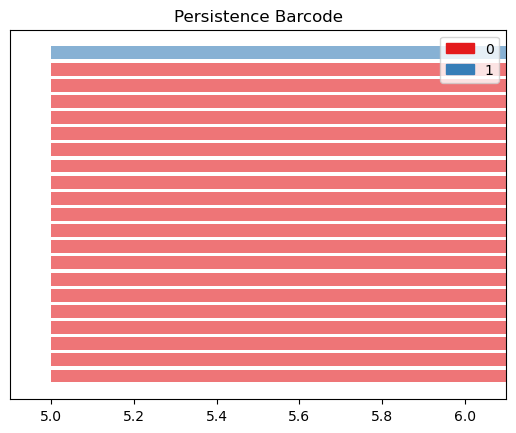

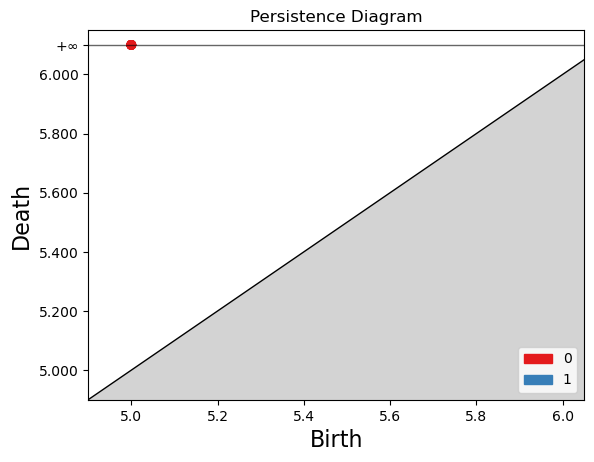

[(1, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf)),
 (0, (5.0, inf))]

In [49]:
X.plot_persistence(tree)

In [38]:
eps = 5

In [96]:
st = X.simplices[5]['tree']

In [97]:
st.get_boundaries()

TypeError: SimplexTree.get_boundaries() takes exactly one argument (0 given)

In [43]:
simplex[2]

[[147, 148, 149],
 [148, 149, 150],
 [149, 150, 151],
 [157, 158, 159],
 [158, 159, 160],
 [159, 160, 161],
 [160, 161, 162],
 [161, 162, 163],
 [174, 175, 176],
 [188, 189, 190],
 [189, 190, 191],
 [197, 198, 199],
 [198, 199, 200],
 [199, 200, 201],
 [201, 202, 203],
 [202, 203, 204],
 [206, 207, 208],
 [207, 208, 209],
 [211, 212, 213],
 [212, 213, 214],
 [213, 214, 215],
 [214, 215, 216],
 [215, 216, 217],
 [216, 217, 218],
 [217, 218, 219],
 [218, 219, 220],
 [219, 220, 221],
 [220, 221, 222],
 [221, 307, 308],
 [221, 222, 308],
 [221, 222, 223],
 [229, 230, 231],
 [230, 231, 232],
 [231, 232, 233],
 [235, 236, 237],
 [236, 237, 238],
 [241, 242, 243],
 [242, 243, 244],
 [243, 244, 245],
 [245, 246, 247],
 [246, 247, 248],
 [247, 248, 249],
 [258, 259, 260],
 [259, 260, 261],
 [260, 261, 262],
 [272, 273, 274],
 [273, 274, 275],
 [274, 275, 276],
 [275, 276, 277],
 [276, 277, 317],
 [277, 317, 318],
 [277, 278, 318],
 [277, 278, 279],
 [281, 282, 283],
 [282, 322, 323],
 [282, 283

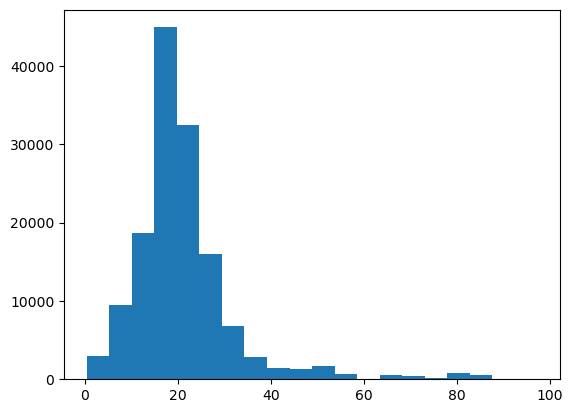

In [160]:
dists = np.triu(X.pairwise_distances, k=1)
dists = dists[dists > 0]
counts, bins, bar = plt.hist(dists, bins=20)

In [46]:
for k in range(6):
    print(k, len(simplex[k]))

0 533
1 2711
2 154
3 64
4 26
5 0


In [199]:
simplex[5]

{(0, 1, 2, 7, 10, 20),
 (6, 22, 23, 24, 36, 38),
 (5, 6, 12, 27, 39, 49),
 (4, 6, 9, 11, 26, 27),
 (3, 5, 11, 21, 27, 36),
 (11, 13, 23, 24, 26, 35),
 (16, 25, 26, 27, 37, 38),
 (7, 34, 39, 44, 47, 51),
 (3, 4, 5, 11, 12, 23),
 (6, 8, 11, 34, 44, 48),
 (0, 9, 16, 19, 20, 24),
 (3, 20, 24, 25, 27, 38),
 (4, 8, 21, 24, 25, 34),
 (3, 7, 13, 17, 24, 25),
 (116, 117, 119, 129, 132, 133),
 (116, 117, 125, 126, 129, 130),
 (26, 34, 35, 38, 48, 50),
 (6, 8, 10, 41, 50, 51),
 (89, 90, 98, 101, 103, 104),
 (9, 36, 39, 45, 46, 47),
 (6, 7, 12, 35, 44, 47),
 (10, 11, 12, 38, 39, 40),
 (35, 40, 41, 42, 45, 52),
 (39, 40, 42, 50, 51, 58),
 (11, 35, 42, 43, 44, 45),
 (6, 8, 38, 41, 48, 51),
 (3, 5, 16, 17, 22, 36),
 (6, 9, 11, 12, 36, 46),
 (2, 7, 24, 26, 37, 38),
 (2, 13, 19, 21, 22, 25),
 (6, 7, 25, 34, 43, 44),
 (10, 11, 21, 26, 35, 38),
 (4, 13, 24, 28, 37, 41),
 (12, 13, 25, 28, 36, 43),
 (8, 13, 19, 25, 27, 37),
 (9, 12, 13, 14, 94, 95),
 (8, 13, 16, 24, 35, 38),
 (34, 42, 44, 45, 47, 48),
 (2,

In [196]:
a = np.array([list(s) for s in simplex[5]])
b = np.array([list(s) for s in simplex[4]])
set(np.unique(b)) >= set(np.unique(a))

True

In [133]:
simplex[1]

KeyError: 1

In [93]:
flag=False
for simp in simplex[6]:
    if(flag):
        break
    for k in range(4, 5):
        if(flag):
            break
        for ks in combinations(simp, k):
            assert len(ks) == k, "huh?"
            if(ks not in simplex[k]):
                flag= True
                print(f"{ks} subset of {simp} not contained")
                break
    

(68, 69, 70, 71) subset of [68, 69, 70, 71, 77, 78] not contained


In [ ]:
simplex

In [62]:
simp = simplex[4][1]
simp

[67, 68, 69, 70]

#### Gudhi Simplex trees

In [79]:
st = gudhi.SimplexTree()
st

In [54]:
#filtration_val = np.ones((len(s), ))*e 
#st.insert_batch(s, filtration_val)

In [ ]:

max_val = np.max(self.pairwise_distances)
E = np.arange(start = 0, stop = max_val + 1, step = max_val/20)

for e in E:
    graph, s = self.construct_simplex(epsilon = e, store = False)
    filtration_val = np.ones((len(s), ))*e 
    st.insert_batch(s, filtration_val)

diagram = st.persistence()

In [55]:
st.insert([0, 1])

True

In [76]:
test = np.array(simplex[4])[:3].T
print(test.shape) # prints (5, 3)
test

(5, 3)


array([[ 77,  78, 113],
       [ 78,  79, 114],
       [ 79,  80, 115],
       [ 80,  81, 116],
       [ 81,  82, 117]])

In [81]:
np.arange(test.shape[1]).shape

(3,)

In [88]:
simplex[4][0]

[77, 78, 79, 80, 81]

In [84]:
st.insert(simplex[4][0])

True

In [87]:
for simplex_with_filtration in st.get_simplices():
    print("(%s, %.2f)" % tuple(simplex_with_filtration))

([77, 78, 79, 80, 81], 0.00)
([77, 78, 79, 80], 0.00)
([77, 78, 79, 81], 0.00)
([77, 78, 79], 0.00)
([77, 78, 80, 81], 0.00)
([77, 78, 80], 0.00)
([77, 78, 81], 0.00)
([77, 78], 0.00)
([77, 79, 80, 81], 0.00)
([77, 79, 80], 0.00)
([77, 79, 81], 0.00)
([77, 79], 0.00)
([77, 80, 81], 0.00)
([77, 80], 0.00)
([77, 81], 0.00)
([77], 0.00)
([78, 79, 80, 81], 0.00)
([78, 79, 80], 0.00)
([78, 79, 81], 0.00)
([78, 79], 0.00)
([78, 80, 81], 0.00)
([78, 80], 0.00)
([78, 81], 0.00)
([78], 0.00)
([79, 80, 81], 0.00)
([79, 80], 0.00)
([79, 81], 0.00)
([79], 0.00)
([80, 81], 0.00)
([80], 0.00)
([81], 0.00)


In [77]:
st = gudhi.SimplexTree()
test = np.array(simplex[4])[:3].T
print(test.shape) # prints (5, 3)
st.insert_batch(test, np.arange(test.shape[1]))

TypeError: Function call with ambiguous argument types

In [74]:
st.find([0, 1])

False

In [57]:
st.insert([0, 1, 2], filtration=4.0)

True

In [59]:
st.dimension()

2

In [60]:
for simplex_with_filtration in st.get_simplices():
    print("(%s, %.2f)" % tuple(simplex_with_filtration))

([0, 1, 2], 4.00)
([0, 1], 0.00)
([0, 2], 4.00)
([0], 0.00)
([1, 2], 4.00)
([1], 0.00)
([2], 4.00)


In [63]:
print("filtration=")
for simplex_with_filtration in st.get_filtration():
    print("(%s, %.2f)" % tuple(simplex_with_filtration))


print("filtration[1, 2]=", st.filtration([1, 2]))
print("filtration[4, 2]=", st.filtration([4, 2]))

filtration=
([0], 0.00)
([1], 0.00)
([0, 1], 0.00)
([2], 4.00)
([0, 2], 4.00)
([1, 2], 4.00)
([0, 1, 2], 4.00)
filtration[1, 2]= 4.0
filtration[4, 2]= inf


In [64]:
print("num_simplices=", st.num_simplices())
print("num_vertices=", st.num_vertices())

num_simplices= 7
num_vertices= 3


In [65]:
print("skeleton[2]=", st.get_skeleton(2))
print("skeleton[1]=", st.get_skeleton(1))
print("skeleton[0]=", st.get_skeleton(0))

skeleton[2]= <generator object at 0x14d507c20>
skeleton[1]= <generator object at 0x14d507c20>
skeleton[0]= <generator object at 0x14d507c20>


In [66]:
for s in st.get_skeleton(2):
    print(s)

([0, 1, 2], 4.0)
([0, 1], 0.0)
([0, 2], 4.0)
([0], 0.0)
([1, 2], 4.0)
([1], 0.0)
([2], 4.0)


In [ ]:
diagram = st.persistence()

In [67]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return 

In [74]:
simp



(67, 68, 69)
(67, 68, 70)
(67, 69, 70)
(68, 69, 70)


In [71]:
list(powerset(simp))

[(67, 68, 69), (67, 68, 70), (67, 69, 70), (68, 69, 70)]

### Applications

In [10]:
X.simplices[5].keys()

dict_keys([4, 6, 5, 3])

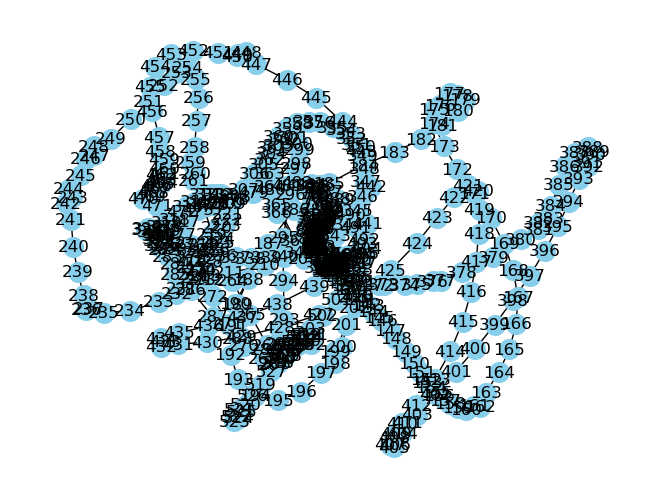

In [25]:
X.draw_graph(X.graphs[5])

In [30]:
simplex = X.simplices[5]
simplex

{10: [[9, 10, 11, 12, 8, 102, 13, 14, 24, 101],
  [9, 10, 11, 12, 8, 102, 13, 14, 24, 23],
  [9, 10, 11, 12, 8, 102, 13, 14, 95, 101],
  [29, 34, 35, 28, 27, 33, 36, 26, 37, 38],
  [55, 56, 64, 57, 58, 59, 60, 61, 62, 63],
  [56, 57, 58, 65, 64, 66, 67, 59, 63, 68],
  [104, 103, 115, 116, 102, 117, 101, 118, 105, 100]],
 9: [[9, 10, 11, 12, 8, 95, 15, 13, 14],
  [9, 10, 11, 12, 94, 15, 13, 14, 95],
  [54, 55, 56, 57, 60, 58, 59, 61, 62],
  [69, 70, 71, 74, 75, 76, 77, 72, 73],
  [104, 103, 115, 116, 102, 117, 114, 118, 105],
  [104, 103, 115, 116, 102, 117, 114, 118, 124],
  [104, 103, 115, 116, 119, 114, 124, 117, 118],
  [114, 115, 116, 117, 118, 124, 120, 123, 119],
  [129, 137, 130, 131, 132, 136, 133, 134, 135],
  [504, 511, 512, 515, 516, 529, 513, 514, 530]],
 8: [[29, 34, 35, 28, 27, 33, 32, 30],
  [29, 34, 35, 28, 31, 32, 33, 30],
  [69, 70, 71, 74, 75, 76, 77, 78],
  [80, 81, 82, 83, 84, 87, 85, 86],
  [81, 88, 82, 83, 84, 85, 86, 87],
  [104, 103, 115, 116, 102, 106, 105, 10

In [ ]:
X.persist_precomputed(k=5)

## Persistent Homology

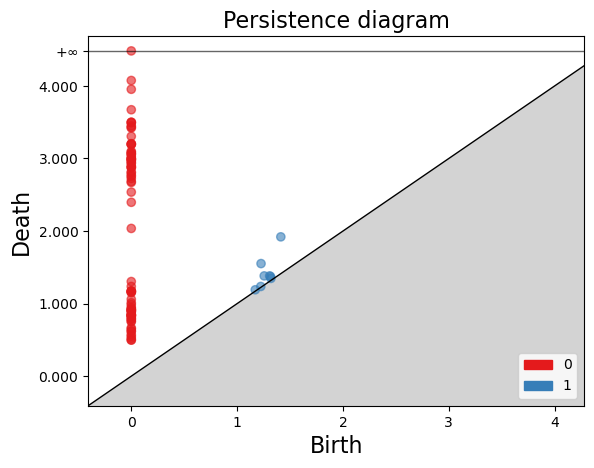

In [25]:
diagam, simplex_tree = X.persist_precomputed(3)

In [29]:
dists = X.compute_pairwise_distances()
dists

array([[0.        , 0.57349036, 0.65840054, ..., 3.4911402 , 3.75260197,
        3.34630335],
       [0.57349036, 0.        , 0.49801565, ..., 3.46380925, 3.75024862,
        3.25692368],
       [0.65840054, 0.49801565, 0.        , ..., 3.38947458, 3.69809969,
        3.26844962],
       ...,
       [3.4911402 , 3.46380925, 3.38947458, ..., 0.        , 4.01152071,
        4.38547023],
       [3.75260197, 3.75024862, 3.69809969, ..., 4.01152071, 0.        ,
        4.67002175],
       [3.34630335, 3.25692368, 3.26844962, ..., 4.38547023, 4.67002175,
        0.        ]])

In [34]:
i = 2
np.where(dists[i, i+1:] < 2)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 12, 14, 15, 16, 17, 18, 19,
        20, 29, 30, 31, 32, 33, 34, 35, 36, 37]),)

In [35]:
dists[i, i+1:]

array([1.17995348, 1.45039407, 1.60482233, 1.65393502, 1.53561934,
       1.7486655 , 1.78616932, 1.50643999, 1.5401123 , 1.93974134,
       2.26613713, 2.18424423, 1.48996839, 2.08316343, 0.97980635,
       1.37030407, 1.69142126, 1.6526694 , 1.71101962, 1.87658025,
       1.91683568, 2.272136  , 2.56948204, 2.77639921, 2.84299438,
       2.71457203, 2.7703281 , 2.51349036, 2.05320489, 1.75858648,
       1.49201337, 1.58488506, 1.78927767, 1.67598013, 1.77275107,
       1.78683886, 1.44940274, 1.42807464, 2.78306396, 2.81550843,
       2.99122636, 3.89086371, 3.2931475 , 3.49736125, 3.64939344,
       3.40331145, 3.88698702, 4.31091633, 3.59040174, 3.66606541,
       3.66847225, 4.34422717, 3.24916106, 3.24701374, 4.109561  ,
       2.94507151, 4.12372592, 3.33126851, 2.62954611, 3.3871806 ,
       3.200731  , 3.35778801, 3.65079989, 4.51996575, 4.53337335,
       3.05065988, 4.2903906 , 3.89643109, 4.03307833, 3.78425343,
       4.262654  , 3.51770088, 3.60648789, 3.71966254, 3.87623

In [32]:


def persist_complex(S, E, plot = True):
    st = gudhi.SimplexTree()

    for i in range(len(S)):

        n = len(S[i][0])

        filtration_val = np.ones((n, ))*E[i]
        st.insert_batch(S[i], filtration_val)

    diagram = st.persistence()
    if plot:
        gudhi.plot_persistence_diagram(diagram)
        plt.show()
    return diagram, st


In [34]:
persist_precomputed(dists, 5)

TypeError: create_simplex_tree() got an unexpected keyword argument 'max_dimensions'

In [30]:
rc

In [25]:
edges = X.connect_edges(epsilon=3)
print(len(X.edges))

NameError: name 'X' is not defined

In [144]:
X.pairwise_distances

array([[        inf,  1.72475681,  2.30785968,  6.91210919,  7.58642893,
         7.14869063],
       [ 1.72475681,         inf,  1.94696002,  7.02451582,  7.24812041,
         7.2019686 ],
       [ 2.30785968,  1.94696002,         inf,  7.24112087,  7.6642744 ,
         6.97137549],
       [ 6.91210919,  7.02451582,  7.24112087,         inf, 10.41200586,
        10.16389849],
       [ 7.58642893,  7.24812041,  7.6642744 , 10.41200586,         inf,
        10.51592152],
       [ 7.14869063,  7.2019686 ,  6.97137549, 10.16389849, 10.51592152,
                inf]])

In [145]:
np.linalg.norm(X.vertices[3] -  X.vertices[1])

7.024515815464485

In [152]:
dists = X.pairwise_distances.flatten()
dists

array([        inf,  1.72475681,  2.30785968,  6.91210919,  7.58642893,
        7.14869063,  1.72475681,         inf,  1.94696002,  7.02451582,
        7.24812041,  7.2019686 ,  2.30785968,  1.94696002,         inf,
        7.24112087,  7.6642744 ,  6.97137549,  6.91210919,  7.02451582,
        7.24112087,         inf, 10.41200586, 10.16389849,  7.58642893,
        7.24812041,  7.6642744 , 10.41200586,         inf, 10.51592152,
        7.14869063,  7.2019686 ,  6.97137549, 10.16389849, 10.51592152,
               inf])